## Optical Flow

Optical flow란 두 개의 연속된 비디오 프레임 사이에 이미지 객체의 가시적인 동작 패턴을 의미한다.  
이미지 객체의 움직임 패턴은 객체 자체가 움직이거나 카메라의 움직임으로 인해 발생한다.

Lucas-Kanade optical flow에는 두 가지 가정이 필요하다.  
1. 객체의 픽셀 intensity는 연속된 프레임 속에서 변하지 않는다.
2. 이웃한 픽셀들 역시 비슷한 움직임을 보인다.

### Code

In [1]:
import numpy as np
import cv2

# params for ShiTomasi corner detection
feature_params = dict(maxCorners=200, qualityLevel=0.01, minDistance=7, blockSize=7)

# Parameters for lucas kanade optical flow
lk_params = dict(winSize=(15,15), maxLevel=2,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# video codec(avi)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
# video resolution should be same
out = cv2.VideoWriter('./op_video.avi', fourcc, 15.0, (1280,720))

class App:
    def __init__(self, video_src):
        self.track_len = 10
        self.detect_interval = 5 # 5frame마다 optical flow 계산하여 검출
        self.tracks = []
        self.cam = cv2.VideoCapture(video_src)
        self.frame_idx = 0
        self.blackscreen = False
        self.width = int(self.cam.get(3))
        self.height = int(self.cam.get(4))
        
    def run(self):
        while True:
            ret, frame = self.cam.read()
            if not ret:
                print("No input to read")
                break
                    
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) #grayscale
            vis = frame.copy() #color
                
            if self.blackscreen: # 배경 off
                vis = np.zeros((self.height, self.width, 3), np.uint8)
            
            # Optical flow 추적
            if len(self.tracks) > 0:
                img0, img1 = self.prev_gray, frame_gray
                p0 = np.float32([tr[-1] for tr in self.tracks]).reshape(-1,1,2)
                p1, st, err = cv2.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
                # arg: 이전 프레임, 이전 검출 포인트들, 다음 프레임
                p0r, st, err =  cv2.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
                d = abs(p0-p0r).reshape(-1, 2).max(-1)
                good = d < 1
                new_tracks = []
                
                for tr, (x,y), good_flag in zip(self.tracks, p1.reshape(-1,2), good):
                    if not good_flag:
                        continue
                            
                    tr.append((x,y))
                    if len(tr) > self.track_len:
                        del tr[0]
                            
                    new_tracks.append(tr)
                    cv2.circle(vis, (x,y), 2, (0,255,0), -1)
                        
                self.tracks = new_tracks
                cv2.polylines(vis, [np.int32(tr) for tr in self.tracks], False, (0,255,0))
                    
            # 비디오 이미지에서의 추적 포인트 결정
            """
            계산된 next 키포인트들이 정확한지 체크하지 않기 때문에,
            비디오 재생이 진행될수록 추적하는 특성 포인트들이 사라질 수 있다.
            따라서 제대로 된 Optical Flow를 구현하려면
            특성 포인트들이 하나의 프레임이 아니라 특정 구간마다 새롭게 계산하여 검출해야 한다.
            """
            if self.frame_idx % self.detect_interval == 0:
                mask = np.zeros_like(frame_gray)
                mask[:] = 255
                for x,y in [np.int32(tr[-1]) for tr in self.tracks]:
                    cv2.circle(mask, (x,y),5,0,-1)
                # Shi-Tomasi 코너 검출
                p = cv2.goodFeaturesToTrack(frame_gray, mask=mask, **feature_params)
                if p is not None:
                    for x,y in np.float32(p).reshape(-1,2):
                        self.tracks.append([(x,y)])
                
            self.frame_idx += 1
            self.prev_gray = frame_gray
                
            cv2.imshow('frame', vis)
            out.write(vis) # VideoWriter 객체에 연속적으로 저장하면 동영상이 됨.
            
            k = cv2.waitKey(30) & 0xFF
            if k == 27:
                break
            if k == ord('b'):
                self.blackscreen = not self.blackscreen
                    
        self.cam.release()
      

In [2]:
video_src = './data/arm.mp4'
App(video_src).run()
cv2.destroyAllWindows()

### Result

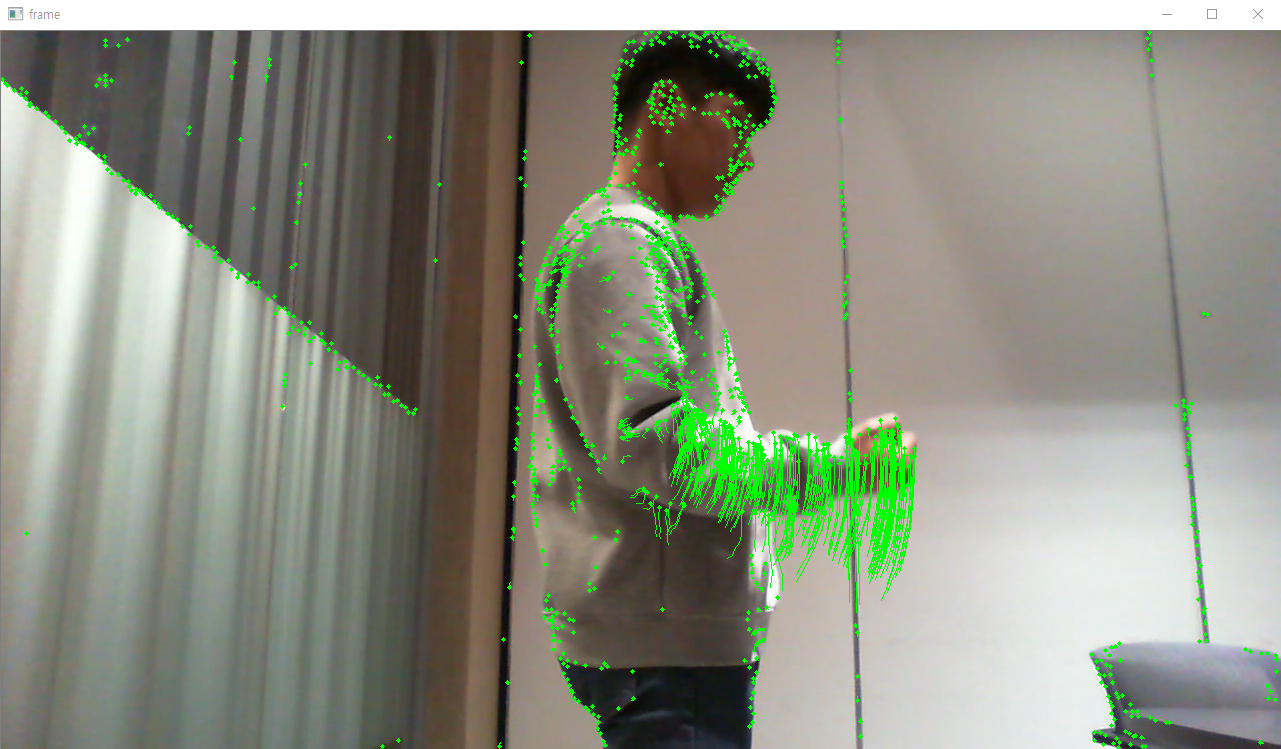

In [1]:
from IPython.display import Image
Image(filename='../data/ex11.png', width=560)

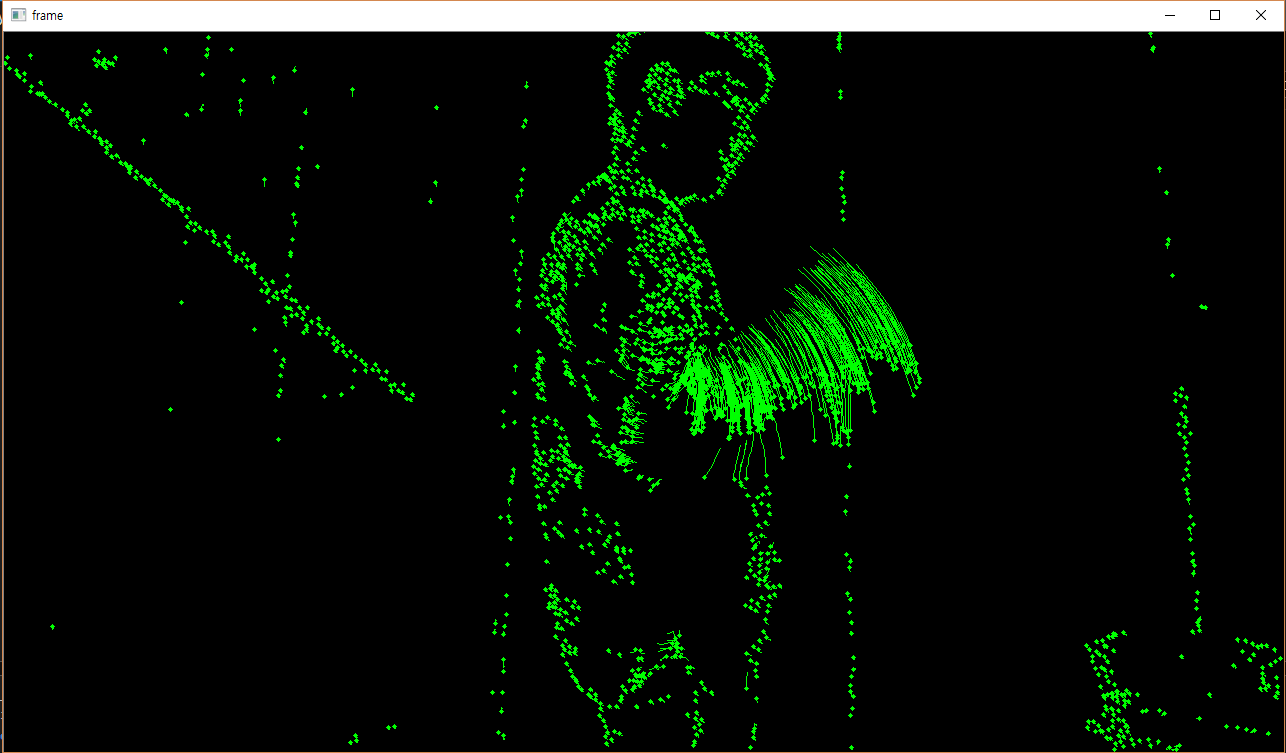

In [2]:
Image(filename='../data/ex12.png', width=560)